# Vector Data Cubes
- 27 April - 2 May 2025
- EGU25, Vienna Austria

- Anshul Singhvi (`@asinghvi17`) - Felix Cremer (`@felixcremer`) - Rafael Schouten (`@rafaqz`)
- **Lazaro Alonso** (`@lazarusA`)

### Install and load packages

#### Installation

In [128]:
using Pkg; Pkg.activate("../Julia")

  Activating project at `~/Documents/EGU25-VectorRaster_DataCubes/Julia`


In [133]:
Pkg.add([
    "Glob",
    "Dates",
    "DataFrames",
    "Shapefile",
    "ArchGDAL",
    "GeoInterface",
    "Proj",
    "Statistics",
    "CairoMakie",
    "LibGEOS",
    "IntervalSets"
    ]
    )

   Resolving package versions...
    Updating `~/Documents/EGU25-VectorRaster_DataCubes/Julia/Project.toml`
  [8197267c] + IntervalSets v0.7.11
  No Changes to `~/Documents/EGU25-VectorRaster_DataCubes/Julia/Manifest.toml`


the bleeding edge devs (soon to be merge)

In [11]:

Pkg.add(url="https://github.com/rafaqz/DimensionalData.jl", rev="main")
Pkg.add(url="https://github.com/JuliaGeo/GeometryOps.jl", rev="as/fix2-preds")
Pkg.add(url="https://github.com/rafaqz/Rasters.jl", rev="as/vectordatacubes")
Pkg.add(url="https://github.com/MakieOrg/Tyler.jl", rev="master")

    Updating git-repo `https://github.com/rafaqz/DimensionalData.jl`
   Resolving package versions...
  No Changes to `~/Documents/EGU25-VectorRaster_DataCubes/Julia/Project.toml`
  No Changes to `~/Documents/EGU25-VectorRaster_DataCubes/Julia/Manifest.toml`
    Updating git-repo `https://github.com/JuliaGeo/GeometryOps.jl`
   Resolving package versions...
  No Changes to `~/Documents/EGU25-VectorRaster_DataCubes/Julia/Project.toml`
  No Changes to `~/Documents/EGU25-VectorRaster_DataCubes/Julia/Manifest.toml`
    Updating git-repo `https://github.com/rafaqz/Rasters.jl`
   Resolving package versions...
  No Changes to `~/Documents/EGU25-VectorRaster_DataCubes/Julia/Project.toml`
  No Changes to `~/Documents/EGU25-VectorRaster_DataCubes/Julia/Manifest.toml`
    Updating git-repo `https://github.com/MakieOrg/Tyler.jl`
   Resolving package versions...
  No Changes to `~/Documents/EGU25-VectorRaster_DataCubes/Julia/Project.toml`
  No Changes to `~/Documents/EGU25-VectorRaster_DataCubes/Jul

#### Loading

In [134]:
using Rasters
using Shapefile
using Proj
using Glob
using ZipFile
using DimensionalData
using Dates
using Statistics
using DataFrames
using CairoMakie
using Tyler
import ArchGDAL
import GeometryOps as GO
import GeoInterface as GI
import LibGEOS
using IntervalSets

### Load LAI

#### read

In [2]:
function read_files(path)
    ras_files = glob("*.tif", path)
    ras_dates = get_dates.(ras_files)
    ras = Raster.(ras_files, lazy=true, name=:data)
    return cat(ras..., dims=Ti(ras_dates))
end
function get_dates(x)
    return DateTime(split(x, r"[_.]")[end-1], "yyyymmddTHHMMSS")
end

get_dates (generic function with 1 method)

Step by step

In [13]:
lai_ds = read_files("../Data/lai_cropped/")

┌ 881×832×77 Raster{Float32, 3} data ┐
├────────────────────────────────────┴─────────────────────────────────── dims ┐
  ↓ X  Projected{Float64} 698940.0:10.0:707740.0 ForwardOrdered Regular Intervals{Start},
  → Y  Projected{Float64} 5.1811e6:-10.0:5.17279e6 ReverseOrdered Regular Intervals{Start},
  ↗ Ti Sampled{DateTime} [2023-04-01T10:15:59, …, 2023-10-30T10:11:41] ForwardOrdered Irregular Points
├──────────────────────────────────────────────────────────────────── metadata ┤
  Metadata{Rasters.GDALsource} of Dict{String, Any} with 1 entry:
  "filepath" => "../Data/lai_cropped/LAI_2023_T32TPS_20230401T101559.tif"
├────────────────────────────────────────────────────────────────────── raster ┤
  extent: Extent(X = (698940.0, 707750.0), Y = (5.17279e6, 5.18111e6), Ti = (DateTime("2023-04-01T10:15:59"), DateTime("2023-10-30T10:11:41")))
  crs: PROJCS["WGS 84 / UTM zone 32N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHE...
└─────────────────────────────────────────────────────────────────────

#### plot

In [4]:
using CairoMakie
set_theme!(theme_light(); size = (600, 350), fontsize=12.5)

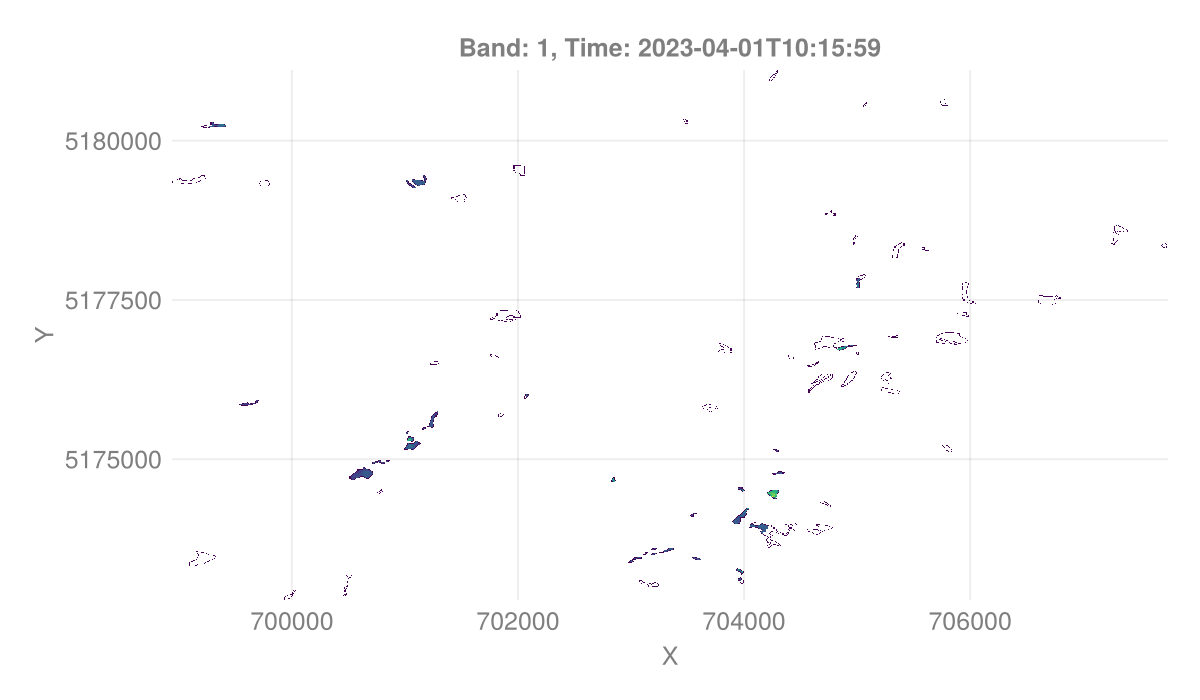

In [6]:
plot(lai_ds[Ti=1])

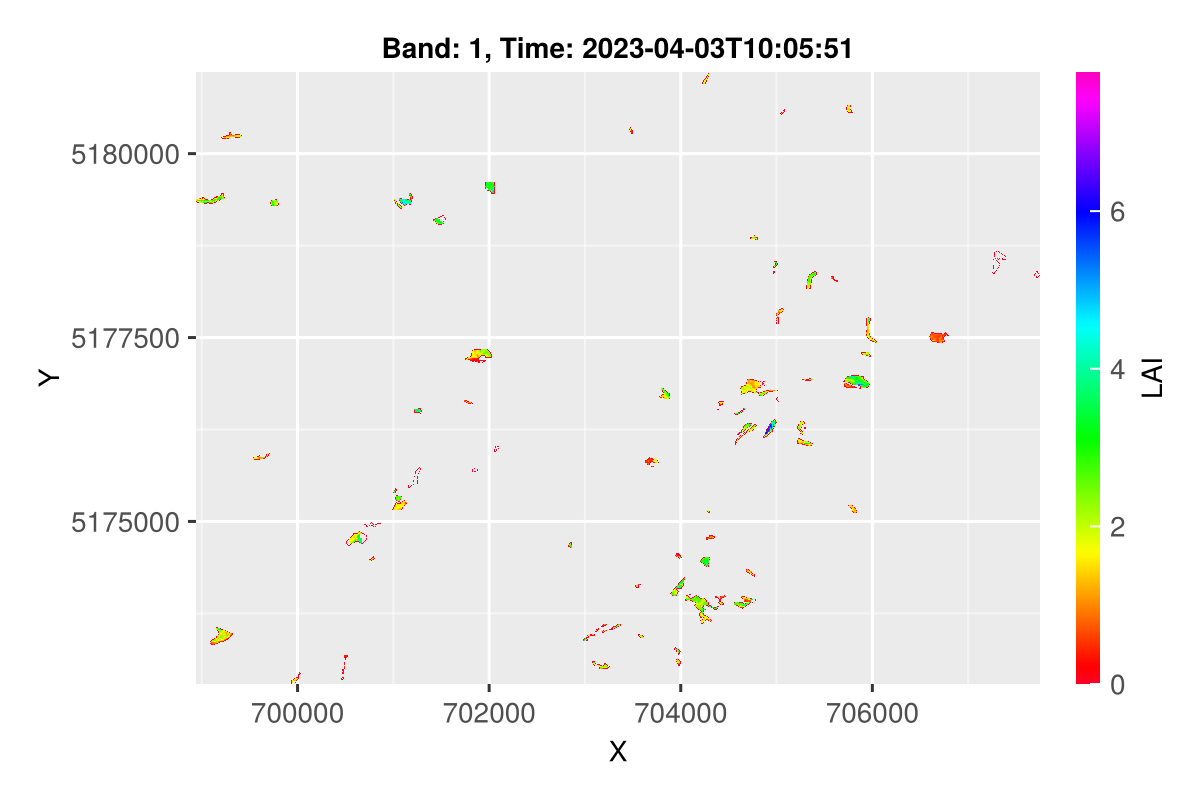

In [9]:
# bonus
fig = with_theme(theme_ggplot2(); size = (600,400)) do 
    fig, ax, plt = plot(lai_ds[Ti=2];
        colormap=:gist_rainbow, #nan_color=:grey95 # ! be mindful with your colormap choices
        )
    Colorbar(fig[1,2], plt, label = "LAI")
    fig
end

visit [ColorSchemes.jl](https://juliagraphics.github.io/ColorSchemes.jl/stable/catalogue/) for more colormaps!

### Load Sentinel-1 RTC data

#### Load and plot ascending data

In [65]:
rtc_asc = read_files("../Data/rtc_asc_cropped/");

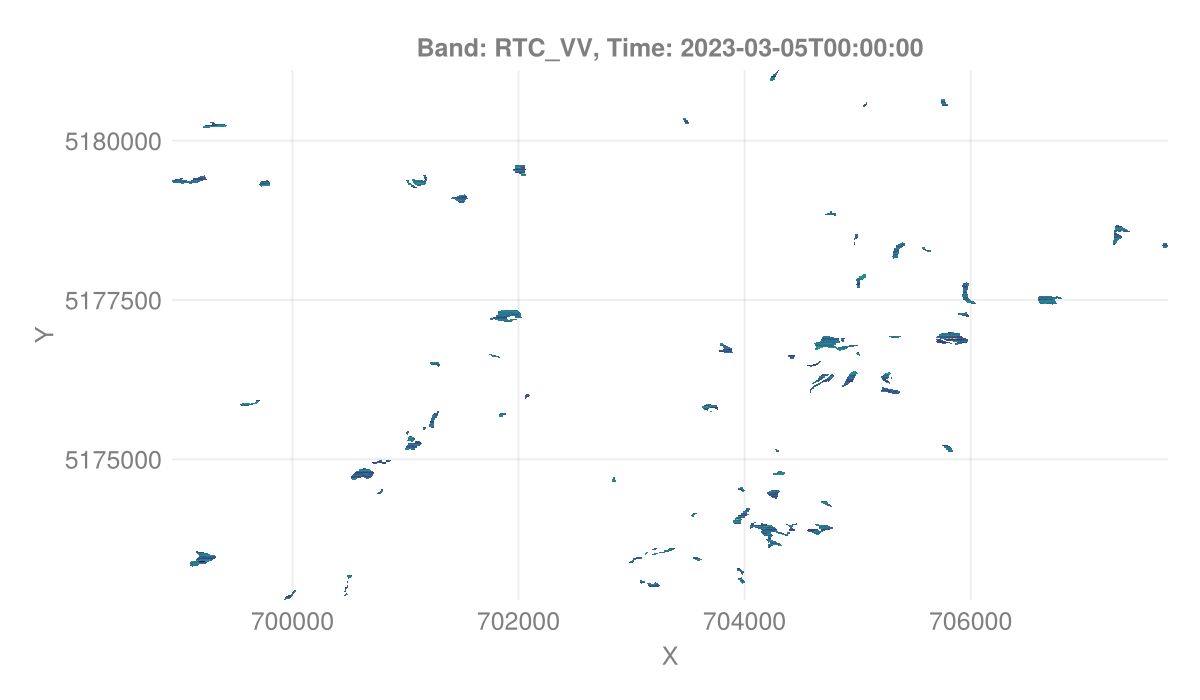

In [66]:
plot(rtc_asc[Ti=1, Band=At("RTC_VV")])

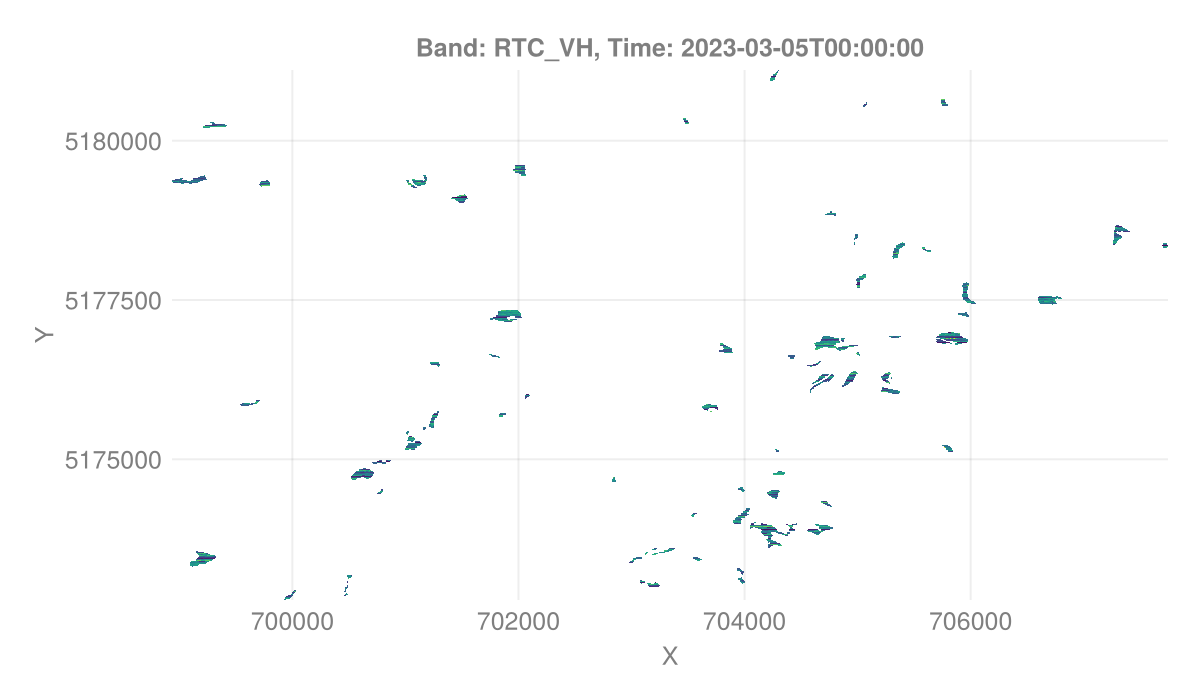

In [67]:
plot(rtc_asc[Ti=1, Band=At("RTC_VH")])

#### Load and plot descending data

In [69]:
rtc_dsc = read_files("../data/rtc_dsc_cropped/");

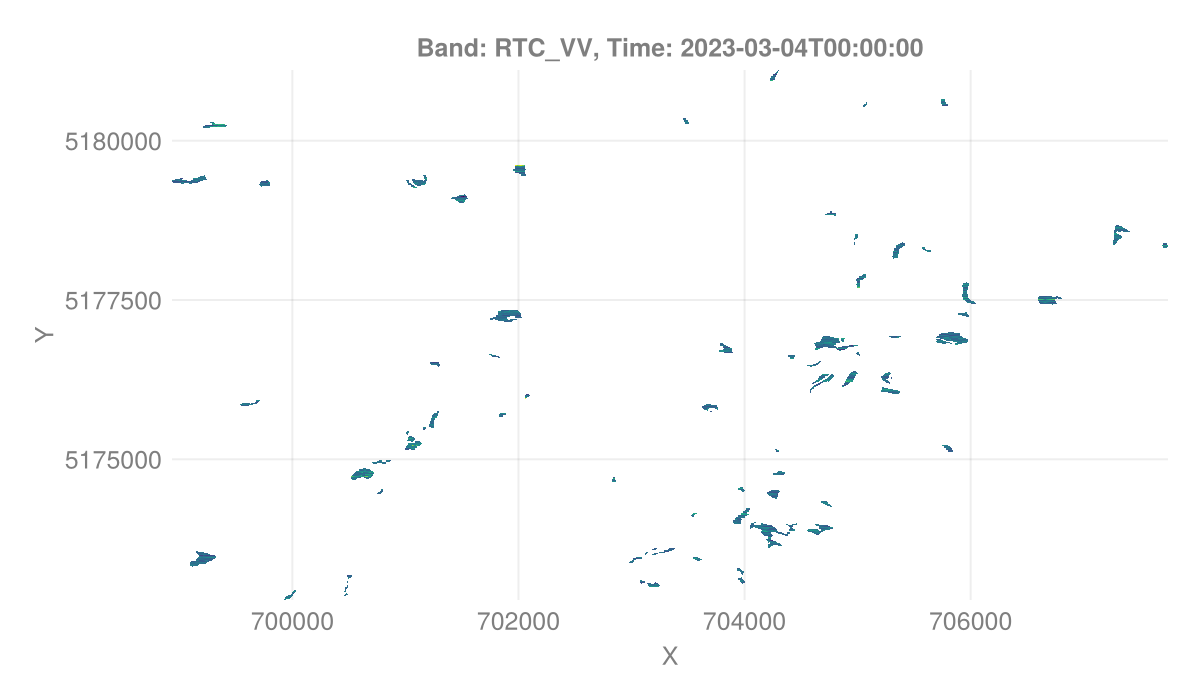

In [70]:
plot(rtc_dsc[Ti=1, Band=At("RTC_VV")])

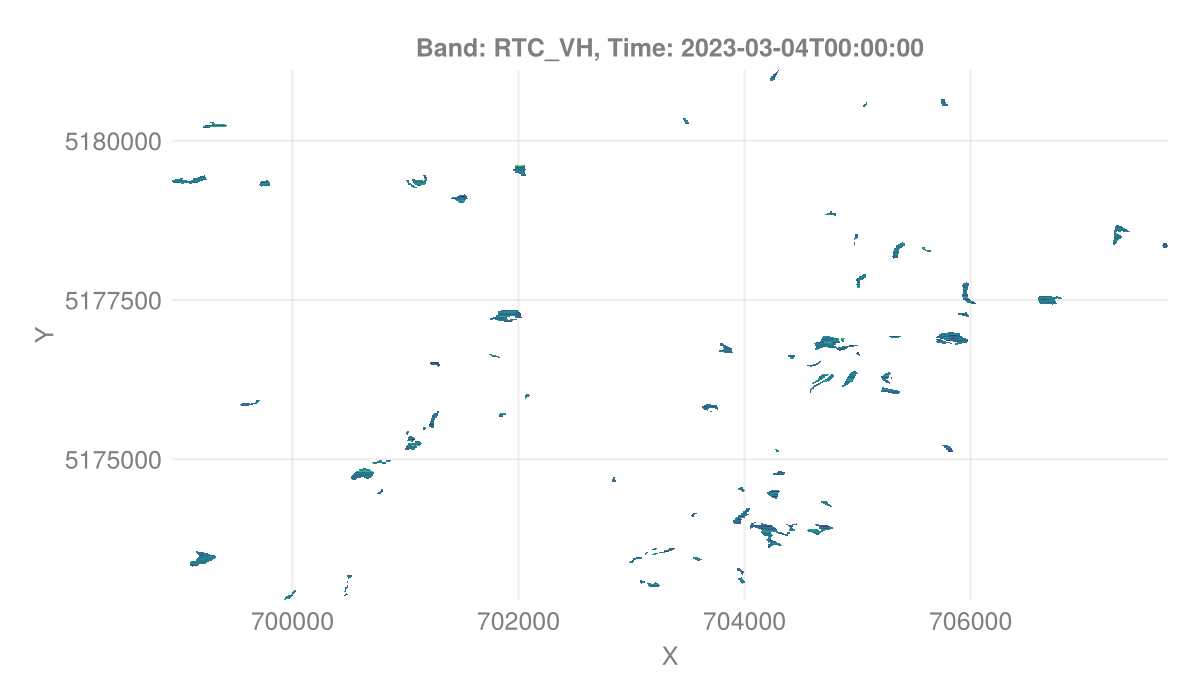

In [71]:
plot(rtc_dsc[Ti=1, Band=At("RTC_VH")])

### Farm polygons

In [22]:
path_farms = "shp/T_LAFIS_32632_buffered_classified_10percent.shp"
farm_polygons = Shapefile.Table(joinpath("../data", path_farms))

Shapefile.Table{Union{Missing, Shapefile.Polygon}} with 3431 rows and the following 11 columns:
	
geometry, ID, CODE, DESCR_IT, DESCR_DE, elev, northness, slope, area, face, class


In [23]:
df = DataFrame(farm_polygons)
first(df, 5)

5×11 DataFrame
 Row │ geometry             ID       CODE     DESCR_IT       DESCR_DE          ⋯
     │ Polygon?             Int64?   String?  String?        String?           ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Polygon(130 Points)  2773902  AP2      Prato stabile  Wiese (Dauerwiese ⋯
   2 │ Polygon(88 Points)   1782222  AP2      Prato stabile  Wiese (Dauerwiese
   3 │ Polygon(32 Points)   3052062  AP2      Prato stabile  Wiese (Dauerwiese
   4 │ Polygon(83 Points)   3106782  AP2      Prato stabile  Wiese (Dauerwiese
   5 │ Polygon(64 Points)   2763340  AP2      Prato stabile  Wiese (Dauerwiese ⋯
                                                               7 columns omitted

#### reprojection

In [26]:
using Proj
farms_4326 = GO.reproject(df; source_crs = EPSG(32632), target_crs = EPSG(4326));

##### Within a bounding box

this is done in `EPSG(4326)`, but it could have been done also in `EPSG(32632)`.

In [31]:
extent_selection = GI.Extent(X = (11.604309, 11.727219), Y = (46.679594, 46.751153));

In [32]:
farms_subset = filter(:geometry => x->GO.intersects(extent_selection, x), farms_4326);

now, we can compute the `centroids` for each `farm` with

In [43]:
farms_subset.centroid = GO.centroid.(farms_subset.geometry)
# GI.DataAPI.metadata!(farms_subset, "GEOINTERFACE:geometrycolumns", (:geometry, :centroid))
first(farms_subset.centroid, 5)

5-element Vector{Tuple{Float64, Float64}}:
 (11.609431443093342, 46.74592285672919)
 (11.621646099258685, 46.681027349457956)
 (11.664702548622955, 46.704916807067875)
 (11.679017952937446, 46.7135664453016)
 (11.685486138758817, 46.70745020061694)

#### Plot on Map

First, reproject the vector data cube to web mercator:


In [44]:
farms_subset_webmercator = GO.reproject(farms_subset;
    source_crs = EPSG(4326),
    target_crs = Tyler.web_mercator);
# and centroids
farms_subset_webmercator_centroids = GO.reproject(farms_subset.centroid;
    source_crs = EPSG(4326),
    target_crs = Tyler.web_mercator
);

In [45]:
map_extent = mapreduce(GI.extent, GI.Extents.union, farms_subset.geometry)

Extent(X = (11.60354533592754, 11.718723769893222), Y = (46.67886789833506, 46.75220253945304))

In [48]:
provider = Tyler.TileProviders.Esri(:WorldImagery)
# provider = Tyler.TileProviders.CartoDB(:DarkMatterNoLabels)
with_theme(theme_dark()) do
    fig = Figure(; size = (800,400)); ax = Axis(fig[1,1])
    # map
    m = Tyler.Map(map_extent; provider, figure = fig, axis = ax)
    # polygons 
    p = poly!(m.axis, farms_subset_webmercator.geometry; color = :dodgerblue,
        strokewidth=0.85, strokecolor=:white)
    # centroids
    scatter!(m.axis, farms_subset_webmercator_centroids; color = :red, marker = 'x', markersize=15)
    hidedecorations!(ax)
    fig
end;

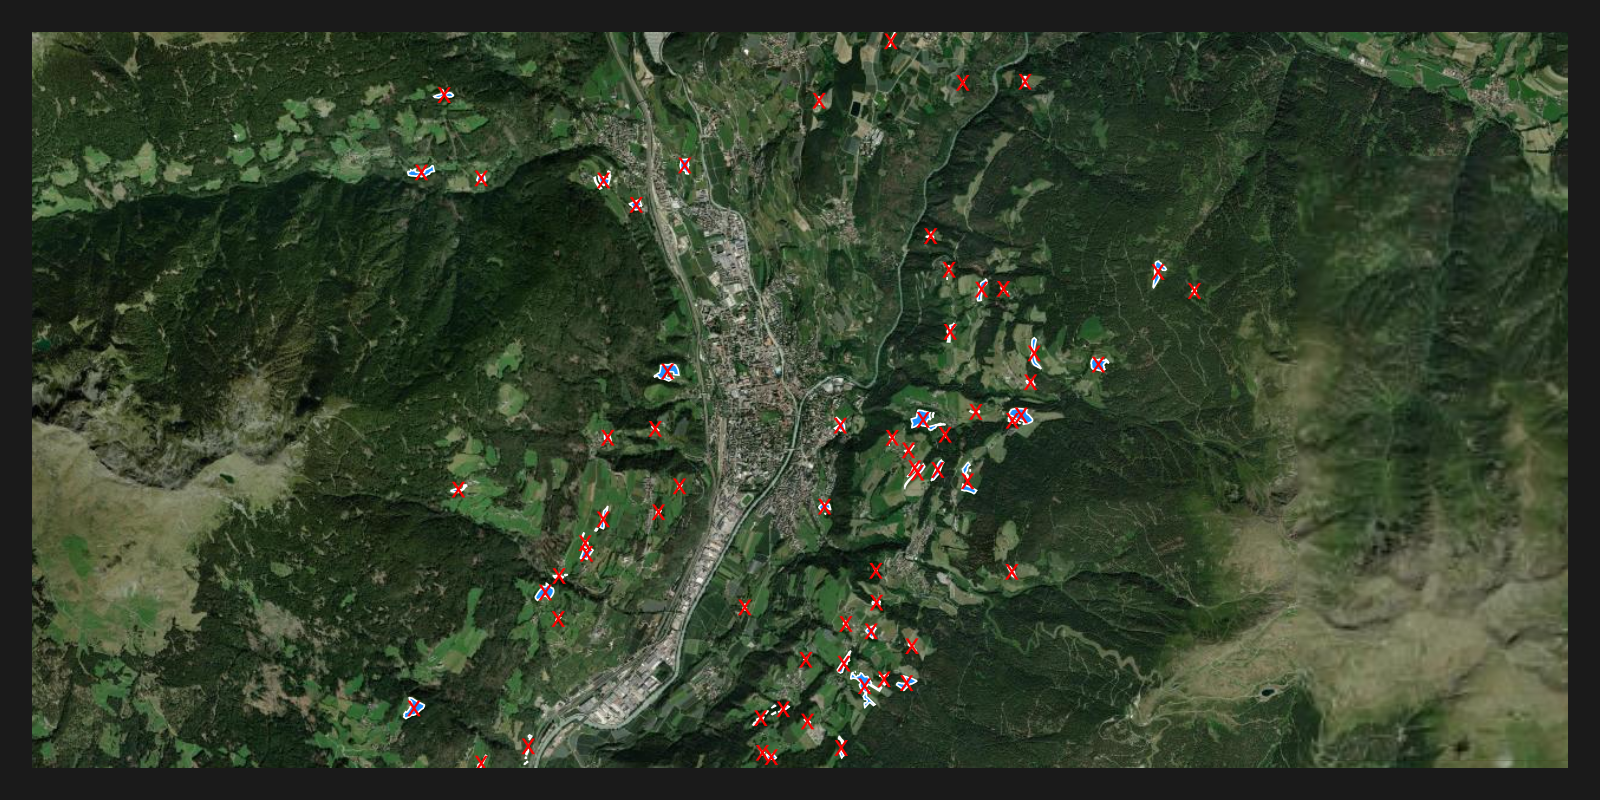

In [50]:
current_figure()

### Featuring engineering for S1

This step focuses on feature engineering for Sentinel-1 (S1) data, highlighting key features such as the VV/VH ratio and the Radar Vegetation Index (RVI) to improve the model performance later.

#### descending:

In [72]:
rtc_dsc_ratio  =  @. rtc_dsc[Band = At("RTC_VV")] / rtc_dsc[Band = At("RTC_VH")]
rtc_dsc_rvi =  @. 4 * rtc_dsc[Band = At("RTC_VH")] / (rtc_dsc[Band = At("RTC_VV")] + rtc_dsc[Band = At("RTC_VH")]);

now, include these as a new `Band`s in `rtc_dsc`.

In [73]:
new_bands = Rasters.Band([dims(rtc_dsc, Rasters.Band)..., "VV/VH", "RVI"]) # collect previous Bands plus the new ones.

Band ["RTC_VV", "RTC_VH", "VV/VH", "RVI"]

In [74]:
rtc_dsc = cat(rtc_dsc[Band=1], rtc_dsc[Band=2], rtc_dsc_ratio, rtc_dsc_rvi; dims=new_bands)

┌ 881×832×45×4 Raster{Union{Missing, Float32}, 4} data ┐
├──────────────────────────────────────────────────────┴───────────────── dims ┐
  ↓ X    Projected{Float64} 698935.421906009:10.0:707735.421906009 ForwardOrdered Regular Intervals{Start},
  → Y    Projected{Float64} 5.181100855994971e6:-10.0:5.172790855994971e6 ReverseOrdered Regular Intervals{Start},
  ↗ Ti   Sampled{DateTime} [2023-03-04T00:00:00, …, 2023-11-30T00:00:00] ForwardOrdered Irregular Points,
  ⬔ Band Categorical{String} ["RTC_VV", "RTC_VH", "VV/VH", "RVI"] Unordered
├──────────────────────────────────────────────────────────────────── metadata ┤
  Metadata{Rasters.GDALsource} of Dict{String, Any} with 1 entry:
  "filepath" => "../data/rtc_dsc_cropped/S1_RTC_dsc_20230304.tif"
├────────────────────────────────────────────────────────────────────── raster ┤
  missingval: missing
  extent: Extent(X = (698935.421906009, 707745.421906009), Y = (5.172790855994971e6, 5.181110855994971e6), Ti = (DateTime("2023-03-04T00:00:0

#### ascending:

In [75]:
rtc_asc_ratio  =  @. rtc_asc[Band = At("RTC_VV")] / rtc_asc[Band = At("RTC_VH")];
rtc_asc_rvi =  @. 4 * rtc_asc[Band = At("RTC_VH")] / (rtc_asc[Band = At("RTC_VV")] + rtc_asc[Band = At("RTC_VH")]);

In [76]:
new_bands = Rasters.Band([dims(rtc_asc, Rasters.Band)..., "VV/VH", "RVI"]) # collect previous Bands plus the new ones.

Band ["RTC_VV", "RTC_VH", "VV/VH", "RVI"]

In [77]:
rtc_asc = cat(rtc_asc[Band=1], rtc_asc[Band=2], rtc_asc_ratio, rtc_asc_rvi; dims=new_bands)

┌ 881×832×65×4 Raster{Union{Missing, Float32}, 4} data ┐
├──────────────────────────────────────────────────────┴───────────────── dims ┐
  ↓ X    Projected{Float64} 698935.421906009:10.0:707735.421906009 ForwardOrdered Regular Intervals{Start},
  → Y    Projected{Float64} 5.181100855994971e6:-10.0:5.172790855994971e6 ReverseOrdered Regular Intervals{Start},
  ↗ Ti   Sampled{DateTime} [2023-03-05T00:00:00, …, 2023-11-26T00:00:00] ForwardOrdered Irregular Points,
  ⬔ Band Categorical{String} ["RTC_VV", "RTC_VH", "VV/VH", "RVI"] Unordered
├──────────────────────────────────────────────────────────────────── metadata ┤
  Metadata{Rasters.GDALsource} of Dict{String, Any} with 1 entry:
  "filepath" => "../Data/rtc_asc_cropped/S1_RTC_asc_20230305.tif"
├────────────────────────────────────────────────────────────────────── raster ┤
  missingval: missing
  extent: Extent(X = (698935.421906009, 707745.421906009), Y = (5.172790855994971e6, 5.181110855994971e6), Ti = (DateTime("2023-03-05T00:00:0

### Extract points

bring back the centroids and farms subset to `EPSG(32632)`:

In [82]:
farms_subset_centroids_32632 = GO.reproject(farms_subset.centroid; source_crs = EPSG(4326), target_crs = EPSG(32632));
farms_subset_32632 = GO.reproject(farms_subset; source_crs = EPSG(4326), target_crs = EPSG(32632));

Extract values from the raster data cubes using farm centroids and randomly distributed points to create representative datasets for model training.

In [84]:
extracted_lai =  Rasters.extract(lai_ds, farms_subset_centroids_32632; skipmissing = false)
extracted_rtc_asc = Rasters.extract(rtc_asc, farms_subset_centroids_32632; skipmissing = false)
extracted_rtc_dsc = Rasters.extract(rtc_dsc, farms_subset_centroids_32632; skipmissing = false);

In [122]:
extracted_lai[Ti=1]

┌ 66-element Raster{@NamedTuple{data::Union{Missing, Float32}}, 1} data ┐
├───────────────────────────────────────────────────────────────────────┴ dims ┐
  ↓ Geometry GeometryLookup{Tuple{Float64, Float64}} [(699317.8881108632, 5.180236879852748e6), (700491.1919111183, 5.173057124782974e6), …, (703196.2692372957, 5.1730285682978155e6), (705339.2837268201, 5.176928379815478e6)] ↓ X, → Y
├──────────────────────────────────────────────────────────────────── metadata ┤
  Metadata{Rasters.GDALsource} of Dict{String, Any} with 1 entry:
  "filepath" => "../Data/lai_cropped/LAI_2023_T32TPS_20230401T101559.tif"
├────────────────────────────────────────────────────────────────────── raster ┤
  extent: Extent(Geometry = ((699093.4758652133, 707720.5722279493), (5.1728497382692965e6, 5.180997949042906e6)),)
└──────────────────────────────────────────────────────────────────────────────┘
 (6.99318e5, 5.18024e6)  @NamedTuple{data::Union{Missing, Float32}}((1.592,))
 (7.00491e5, 5.17306e6)  @NamedTu

#### zonal

In [114]:
# lai
aggregated_lai_farms = zonal(mean, lai_ds, of=GeometryLookup(farms_subset_32632),
    threaded = true, skipmissing = true, spatialslices = true);
# all(isnan, aggregated_lai_farms), all(ismissing, aggregated_lai_farms)
# ascending
aggregated_rtc_asc_farms = zonal(mean, rtc_asc, of=GeometryLookup(farms_subset_32632),
    threaded = true, skipmissing = true, spatialslices = true)
# descending
aggregated_rtc_dsc_farms = zonal(mean, rtc_dsc, of=GeometryLookup(farms_subset_32632),
    threaded = true, skipmissing = true, spatialslices = true);


Applying mean to each geometry... 100%|██████████████████████████████████████████████████| Time: 0:00:01
Applying mean to each geometry... 100%|██████████████████████████████████████████████████| Time: 0:00:00
Applying mean to each geometry... 100%|██████████████████████████████████████████████████| Time: 0:00:00


In [115]:
aggregated_rtc_asc_farms[Ti=1]

┌ 4×66 Raster{Float32, 2} data ┐
├──────────────────────────────┴───────────────────────────────────────── dims ┐
  ↓ Band     Categorical{String} ["RTC_VV", "RTC_VH", "VV/VH", "RVI"] Unordered,
  → Geometry GeometryLookup{GeoInterface.Wrappers.MultiPolygon{false, false, Vector{GeoInterface.Wrappers.Polygon{false, false, Vector{GeoInterface.Wrappers.LinearRing{false, false, Vector{Tuple{Float64, Float64}}, Nothing, EPSG{1}}}, Nothing, EPSG{1}}}, Nothing, EPSG{1}}} [GeoInterface.Wrappers.MultiPolygon{false, false}([GeoInterface.Wrappers.Polygon([GeoInterface.Wrappers.LinearRing([(699211.6412465982, 5.180209025860044e6), … (86) … , (699211.6412465982, 5.180209025860044e6)], crs = "EPSG:32632")], crs = "EPSG:32632")], crs = "EPSG:32632"), GeoInterface.Wrappers.MultiPolygon{false, false}([GeoInterface.Wrappers.Polygon([GeoInterface.Wrappers.LinearRing([(700463.6406007136, 5.172926726420797e6), … (12) … , (700463.6406007136, 5.172926726420797e6)], crs = "EPSG:32632")], crs = "EPSG:32632"), 

In [116]:
aggregated_rtc_dsc_farms[Ti=1]

┌ 4×66 Raster{Float32, 2} data ┐
├──────────────────────────────┴───────────────────────────────────────── dims ┐
  ↓ Band     Categorical{String} ["RTC_VV", "RTC_VH", "VV/VH", "RVI"] Unordered,
  → Geometry GeometryLookup{GeoInterface.Wrappers.MultiPolygon{false, false, Vector{GeoInterface.Wrappers.Polygon{false, false, Vector{GeoInterface.Wrappers.LinearRing{false, false, Vector{Tuple{Float64, Float64}}, Nothing, EPSG{1}}}, Nothing, EPSG{1}}}, Nothing, EPSG{1}}} [GeoInterface.Wrappers.MultiPolygon{false, false}([GeoInterface.Wrappers.Polygon([GeoInterface.Wrappers.LinearRing([(699211.6412465982, 5.180209025860044e6), … (86) … , (699211.6412465982, 5.180209025860044e6)], crs = "EPSG:32632")], crs = "EPSG:32632")], crs = "EPSG:32632"), GeoInterface.Wrappers.MultiPolygon{false, false}([GeoInterface.Wrappers.Polygon([GeoInterface.Wrappers.LinearRing([(700463.6406007136, 5.172926726420797e6), … (12) … , (700463.6406007136, 5.172926726420797e6)], crs = "EPSG:32632")], crs = "EPSG:32632"), 

### Buffer and selecting (indexing) farm [geometry]

In [125]:
# Select a specific farm
farm_id = 1782222
selected_farm = filter(:ID => ==(farm_id), farms_subset_32632)
geom = only(selected_farm.geometry)

GeoInterface.Wrappers.MultiPolygon{false, false}([GeoInterface.Wrappers.Polygon([GeoInterface.Wrappers.LinearRing([(699211.6412465982, 5.180209025860044e6), … (86) … , (699211.6412465982, 5.180209025860044e6)], crs = "EPSG:32632")], crs = "EPSG:32632")], crs = "EPSG:32632")

In [126]:
# Select S1 ASC RTC data based on the geometry of the selected farm
selected_farm = aggregated_rtc_asc_farms[Geometry=At(geom)]

┌ 65×4 Raster{Float32, 2} data ┐
├──────────────────────────────┴───────────────────────────────────────── dims ┐
  ↓ Ti   Sampled{DateTime} [2023-03-05T00:00:00, …, 2023-11-26T00:00:00] ForwardOrdered Irregular Points,
  → Band Categorical{String} ["RTC_VV", "RTC_VH", "VV/VH", "RVI"] Unordered
├──────────────────────────────────────────────────────────────────── metadata ┤
  Metadata{Rasters.GDALsource} of Dict{String, Any} with 1 entry:
  "filepath" => "../Data/rtc_asc_cropped/S1_RTC_asc_20230305.tif"
├────────────────────────────────────────────────────────────────────── raster ┤
  extent: Extent(Ti = (DateTime("2023-03-05T00:00:00"), DateTime("2023-11-26T00:00:00")), Band = (nothing, nothing))
└──────────────────────────────────────────────────────────────────────────────┘
 ↓ →                      "RTC_VV"     "RTC_VH"   "VV/VH"   "RVI"
  2023-03-05T00:00:00   -9.56456    -16.5082     0.571877  2.56
  2023-03-07T00:00:00  -10.4428     -17.1703     0.609914  2.4925
 ⋮              

Select LAI data `within 2.5 km around the geometry` of the selected farm

In [131]:
buffered_geom = GO.buffer(geom, 2500)
datacube_lai_farms = aggregated_lai_farms[Geometry = Where(Base.Fix1(GO.intersects, buffered_geom))]

┌ 77×5 Raster{Float32, 2} data ┐
├──────────────────────────────┴───────────────────────────────────────── dims ┐
  ↓ Ti       Sampled{DateTime} [2023-04-01T10:15:59, …, 2023-10-30T10:11:41] ForwardOrdered Irregular Points,
  → Geometry GeometryLookup{GeoInterface.Wrappers.MultiPolygon{false, false, Vector{GeoInterface.Wrappers.Polygon{false, false, Vector{GeoInterface.Wrappers.LinearRing{false, false, Vector{Tuple{Float64, Float64}}, Nothing, EPSG{1}}}, Nothing, EPSG{1}}}, Nothing, EPSG{1}}} [GeoInterface.Wrappers.MultiPolygon{false, false}([GeoInterface.Wrappers.Polygon([GeoInterface.Wrappers.LinearRing([(699211.6412465982, 5.180209025860044e6), … (86) … , (699211.6412465982, 5.180209025860044e6)], crs = "EPSG:32632")], crs = "EPSG:32632")], crs = "EPSG:32632"), GeoInterface.Wrappers.MultiPolygon{false, false}([GeoInterface.Wrappers.Polygon([GeoInterface.Wrappers.LinearRing([(701012.8246198455, 5.17937719139658e6), … (25) … , (701012.8246198455, 5.17937719139658e6)], crs = "EPSG:3263

### Data cleaning, matching with 3 day tolerance

In [ ]:
lai_timeaxis = dims(lai_ds, Ti)
rtc_lai = [rtc_asc[Ti=(dt - Day(3))..(dt + Day(3))] for dt in lai_timeaxis]
#ct = ClosedInterval.(dt .- Day(3), dt .+Day(3))
rtc_lai = filter(x-> !iszero(size(x, Ti)), rtc_lai);
@show size.(rtc_lai, Ti)
mrtc_lai = mean.(rtc_lai, dims=Ti)
merged_asc_lai = cat(mrtc_lai..., dims=dims(lai_da, Ti)[2:end])

In [142]:
dt = dims(lai_ds, Ti)
tolerance_interval = ClosedInterval.(dt .- Day(3), dt .+ Day(3))
first(tolerance_interval, 3)

┌ 3-element DimArray{ClosedInterval{DateTime}, 1} ┐
├─────────────────────────────────────────────────┴────────────────────── dims ┐
  ↓ Ti Sampled{DateTime} [2023-04-01T10:15:59, …, 2023-04-06T10:20:21] ForwardOrdered Irregular Points
└──────────────────────────────────────────────────────────────────────────────┘
 2023-04-01T10:15:59  2023-03-29T10:15:59 .. 2023-04-04T10:15:59
 2023-04-03T10:05:51  2023-03-31T10:05:51 .. 2023-04-06T10:05:51
 2023-04-06T10:20:21  2023-04-03T10:20:21 .. 2023-04-09T10:20:21

In [145]:
asc_match =  filter(x-> !iszero(size(x, Ti)),
    getindex.((aggregated_rtc_asc_farms,), Ti.(tolerance_interval)));